In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from common_import import *
from hpe_library.pcl_utils import *

# H36M

In [2]:
data_type_list = ['source_list', 'cam_param', 
                  'cam_3d', 'img_2d', 
                  'cam_3d_canonical_pcl_original', 'img_2d_canonical_pcl_original', 
                  'img_2d_canonical_pcl', 'img_2d_canonical_pcl_with_Rz']
overwrite_list = []
dataset_name = 'h36m'
data_aug = default_data_aug.copy()
data = load_data_dict(dataset_name, data_type_list, overwrite_list, verbose=True, data_aug=data_aug)

[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M cam_3d...
[overwrite: False] ==> Loading H36M img_2d...
[overwrite: False] ==> Loading H36M cam_3d_canonical_pcl_original...
[overwrite: False] ==> Loading H36M img_2d_canonical_pcl_original...
[overwrite: False] ==> Loading H36M img_2d_canonical_pcl...
[overwrite: False] ==> Loading H36M img_2d_canonical_pcl_with_Rz...


In [10]:
# subject = 'S9'
# action = 'Walking 1'
# cam_id = '54138969'
source_list = data['source_list'].copy()
subject, cam_id, action = split_source_name(source_list[50], dataset_name)

# camera parameters
cam_param = data['cam_param'][subject][action][cam_id].copy()
W, H, intrinsic = cam_param['W'], cam_param['H'], cam_param['intrinsic']
fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]
# original 3D/2D pose
cam_3d = data['cam_3d'][subject][action][cam_id].copy() #+ np.array([1, 0, -3])
img_2d = projection(cam_3d, intrinsic) # data['img_2d'][subject][action][cam_id].copy()
# root-relative 3D pose
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]
# input centered 2D pose
img_2d_centered = img_2d.copy() - img_2d[:, 0:1] + np.array([cx, cy])
# canonical 3D/2D pose by GT (same_z)
cam_3d_canonical = canonicalization_cam_3d(cam_3d, canonical_type='same_z')
img_2d_canonical = projection(cam_3d_canonical, intrinsic) # data['img_2d_canonical_same_z'][subject][action][cam_id].copy()

## R_virt2orig
R_orig2virt_no_Rz_from_2d, R_orig2virt_no_Rz_from_2d_inv = get_batch_R_orig2virt_from_2d(img_2d, intrinsic)
R_orig2virt_no_Rz_from_3d, R_orig2virt_no_Rz_from_3d_inv = get_batch_R_orig2virt_from_3d(cam_3d, no_Rz=True)
R_orig2virt_from_3d, R_orig2virt_from_3d_inv = get_batch_R_orig2virt_from_3d(cam_3d, no_Rz=False)

## canonical_revolute_no_Rz 3D/2D pose
cam_3d_canonical_revolute_no_Rz = np.einsum('ijk,ikl->ijl', cam_3d, R_orig2virt_no_Rz_from_2d_inv)
img_2d_canonical_revolute_no_Rz = projection(cam_3d_canonical_revolute_no_Rz, intrinsic)

## canonical_revolute 3D/2D pose
cam_3d_canonical_revolute = np.einsum('ijk,ikl->ijl', cam_3d, R_orig2virt_from_3d_inv)
img_2d_canonical_revolute = projection(cam_3d_canonical_revolute, intrinsic)

## PCL with original K
K_inv = np.linalg.inv(intrinsic)
norm_2d = img_2d.copy() # np.stack([img_2d, np.ones([img_2d.shape[0], img_2d.shape[1], 1])])
norm_2d = np.concatenate([norm_2d, np.ones((norm_2d.shape[0], norm_2d.shape[1], 1))], axis=-1)
norm_2d = norm_2d @ K_inv.T
norm_2d_virt_no_Rz = np.einsum('ijk,ikl->ijl', norm_2d, R_orig2virt_no_Rz_from_2d_inv)
norm_2d_virt_with_Rz = np.einsum('ijk,ikl->ijl', norm_2d, R_orig2virt_from_3d_inv)
img_2d_canonical_pcl = projection(norm_2d_virt_no_Rz, intrinsic)
img_2d_canonical_pcl_with_Rz = projection(norm_2d_virt_with_Rz, intrinsic)

## Original PCL
location_px = img_2d[:, 0]
scale_y = img_2d[...,1].max(axis=-1) - img_2d[...,1].min(axis=-1)
scale_x = img_2d[...,0].max(axis=-1) - img_2d[...,0].min(axis=-1)
scale = np.stack([scale_x, scale_y], axis=-1)

img_2d_tensor = torch.tensor(img_2d).float()
scale_tensor = torch.tensor(scale).float()
Ks_px_orig_tensor = torch.tensor(intrinsic.reshape(1, 3, 3)).repeat(img_2d.shape[0], 1, 1).float()
location_px_tensor = torch.tensor(location_px).float()

img_2d_canonical_pcl_original, R_virt2orig, P_virt2orig = pcl.pcl_transforms_2d(img_2d_tensor,
                                                                                location_px_tensor,
                                                                                scale_tensor,
                                                                                Ks_px_orig_tensor,
                                                                                focal_at_image_plane=True,
                                                                                slant_compensation=True)
cam_3d_canonical_pcl_original = np.einsum('ijk,ikl->ijl', cam_3d, R_virt2orig)
R_orig2virt = R_virt2orig.inverse()

print('error between R_orig2virt_no_Rz_from_2d from pcl and R_orig2virt_no_Rz_from_3d', np.abs(R_orig2virt_no_Rz_from_2d - R_orig2virt_no_Rz_from_3d).mean())
print('error between R_orig2virt from pcl and R_orig2virt_no_Rz_from_2d', np.abs(R_orig2virt.detach().cpu().numpy() - R_orig2virt_no_Rz_from_2d).mean())
print('error between R_orig2virt from pcl and R_orig2virt_no_Rz_from_3d', np.abs(R_orig2virt.detach().cpu().numpy() - R_orig2virt_no_Rz_from_3d).mean())

error between R_orig2virt_no_Rz_from_2d from pcl and R_orig2virt_no_Rz_from_3d 5.604965048609469e-17
error between R_orig2virt from pcl and R_orig2virt_no_Rz_from_2d 2.3204113250163535e-08
error between R_orig2virt from pcl and R_orig2virt_no_Rz_from_3d 2.320411325135683e-08


In [5]:
np.linalg.norm(img_2d_canonical_pcl_original - data['img_2d_canonical_pcl_original'][subject][action][cam_id].copy(), axis=-1).mean()

0.0

In [6]:
np.linalg.norm(img_2d_canonical_revolute_no_Rz - data['img_2d_canonical_pcl'][subject][action][cam_id].copy(), axis=-1).mean()

9.660362430955547e-14

In [7]:
np.linalg.norm(img_2d_canonical_revolute - data['img_2d_canonical_pcl_with_Rz'][subject][action][cam_id].copy(), axis=-1).mean()

1.0715869946142877e-13

In [ ]:

total_error_R_orig2virt_btw_pcl_no_Rz_from_2d = 0
total_error_R_orig2virt_btw_pcl_no_Rz_from_3d = 0
for source in tqdm(source_list):
    subject, cam_id, action = split_source_name(source_list[50], dataset_name)

    # camera parameters
    cam_param = data['cam_param'][subject][action][cam_id].copy()
    W, H, intrinsic = cam_param['W'], cam_param['H'], cam_param['intrinsic']

    R_orig2virt_no_Rz_from_2d, R_orig2virt_no_Rz_from_2d_inv = get_batch_R_orig2virt_from_2d(img_2d, intrinsic)
    R_orig2virt_no_Rz_from_3d, R_orig2virt_no_Rz_from_3d_inv = get_batch_R_orig2virt_from_3d(cam_3d, no_Rz=True)

    location_px = img_2d[:, 0]
    scale_y = img_2d[...,1].max(axis=-1) - img_2d[...,1].min(axis=-1)
    scale_x = img_2d[...,0].max(axis=-1) - img_2d[...,0].min(axis=-1)
    scale = np.stack([scale_x, scale_y], axis=-1)

    img_2d_tensor = torch.tensor(img_2d).float()
    scale_tensor = torch.tensor(scale).float()
    Ks_px_orig_tensor = torch.tensor(intrinsic.reshape(1, 3, 3)).repeat(img_2d.shape[0], 1, 1).float()
    location_px_tensor = torch.tensor(location_px).float()

    img_2d_canonical_pcl_original, R_virt2orig, P_virt2orig = pcl.pcl_transforms_2d(img_2d_tensor,
                                                                                    location_px_tensor,
                                                                                    scale_tensor,
                                                                                    Ks_px_orig_tensor,
                                                                                    focal_at_image_plane=True,
                                                                                    slant_compensation=True)
    R_orig2virt = R_virt2orig.inverse()

    total_error_R_orig2virt_btw_pcl_no_Rz_from_2d += np.abs(R_orig2virt.detach().cpu().numpy() - R_orig2virt_no_Rz_from_2d).mean()
    total_error_R_orig2virt_btw_pcl_no_Rz_from_3d += np.abs(R_orig2virt.detach().cpu().numpy() - R_orig2virt_no_Rz_from_3d).mean()
    

  0%|          | 0/836 [00:00<?, ?it/s]

100%|██████████| 836/836 [00:15<00:00, 54.57it/s]


In [28]:
total_error_R_orig2virt_btw_pcl_no_Rz_from_2d/len(source_list), total_error_R_orig2virt_btw_pcl_no_Rz_from_3d/len(source_list)

(2.3204113250163078e-08, 2.320411325135664e-08)

Already exists: /home/hrai/codes/MotionBERT/S1_SittingDown_55011271_pcl_input.mp4


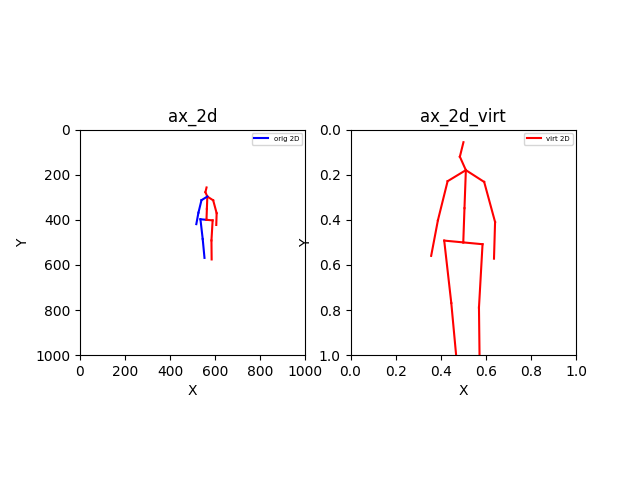

In [13]:
%matplotlib widget
# check original train data
frame_num = 0
configs = {
    'ax_2d': {'type': '2d', 'loc': 121, 'W': W, 'H': H},
    'ax_2d_virt': {'type': '2d', 'loc': 122, 'W': 1, 'H': 1},
}

fig, axs = generate_axes(1, configs, fig_title='')
plot_pose_setting = [
    ('ax_2d', img_2d,             {'color': '', 'label': 'orig 2D'}),
    ('ax_2d_virt', img_2d_canonical_pcl_original, {'color': 'r', 'label': 'virt 2D'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
#plt.show()

# save video
save_folder = '.'
generate_plot_video(fig, f'{save_folder}/{subject}_{action}_{cam_id}_pcl_input.mp4', len(img_2d), lambda x: general_plot_func(axs, configs, plot_pose_setting, x), fps=5, stride=6, overwrite=False)

In [38]:
np.linalg.norm(cam_3d_canonical_pcl_original - cam_3d_canonical_revolute_no_Rz, axis=-1).mean()

2.457410617083273e-07

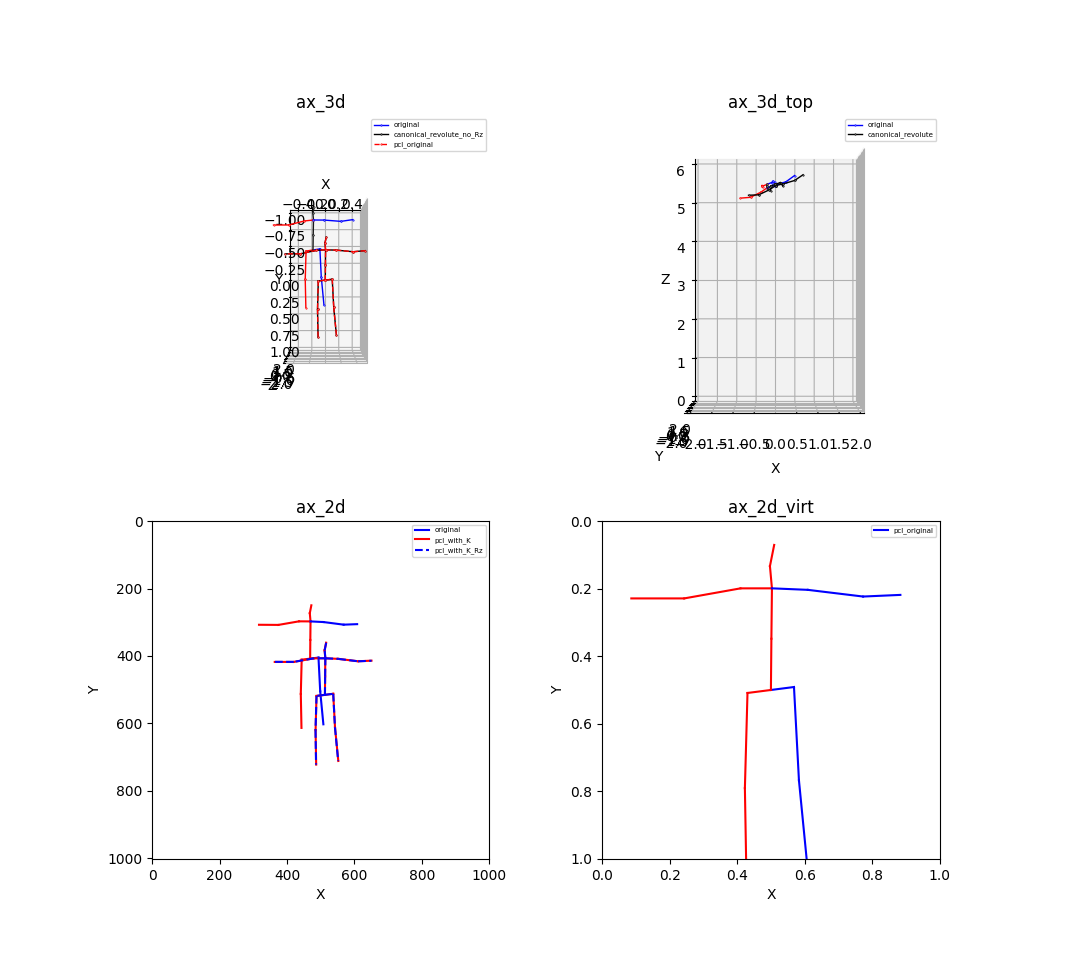

In [44]:
## check original train data
frame_num = 0
configs = {
    'ax_3d': {'type': '3d', 'loc': 221, 'mode': 'cam', 'xlim': [-0.5, 0.5], 'ylim': [-1, 1]},
    'ax_3d_top': {'type': '3d', 'loc': 222, 'mode': 'cam_top', 'zlim': [0, 6]},
    'ax_2d': {'type': '2d', 'loc': 223, 'W': W, 'H': H},
    'ax_2d_virt': {'type': '2d', 'loc': 224, 'W': 1, 'H': 1},
}
fig, axs = generate_axes(2, configs, fig_title='')
plot_pose_setting = [
    ('ax_3d', cam_3d,                               {'color': '', 'label': 'original'}),
    #('ax_3d', cam_3d_canonical_revolute,            {'color': 'k', 'label': 'canonical_revolute'}),
    ('ax_3d', cam_3d_canonical_revolute_no_Rz,      {'color': 'k', 'label': 'canonical_revolute_no_Rz'}),
    ('ax_3d', cam_3d_canonical_pcl_original,        {'color': 'r', 'label': 'pcl_original', 'linestyle': '--'}),
    ('ax_3d_top', cam_3d,                           {'color': '', 'label': 'original'}),
    ('ax_3d_top', cam_3d_canonical_revolute,        {'color': 'k', 'label': 'canonical_revolute'}),
    ('ax_2d', img_2d,                               {'color': '', 'label': 'original'}),
    ('ax_2d', img_2d_canonical_pcl,                 {'color': 'r', 'label': 'pcl_with_K'}),
    ('ax_2d', img_2d_canonical_pcl_with_Rz,         {'color': 'b', 'label': 'pcl_with_K_Rz', 'linestyle': '--'}),
    ('ax_2d_virt', img_2d_canonical_pcl_original,   {'color': '', 'label': 'pcl_original'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
# plt.sca(axs['ax_3d'])
# # camera
# camera = Camera(origin=np.array([0, 0, 0]),
#                 calib_mat=intrinsic,
#                 cam_default_R=np.eye(3),
#                 IMAGE_HEIGHT=H,
#                 IMAGE_WIDTH=W,
#                 cam_name='cam_frame')
# camera.cam_frame.draw3d(show_name=False)
plt.show()

# 3DHP

In [9]:
data_type_list = [
     'source_list', 'cam_param', 
     'cam_3d', 'img_2d',
     'cam_3d_canonical_revolute_no_Rz', 'img_2d_canonical_revolute_no_Rz',
     'cam_3d_canonical_revolute', 'img_2d_canonical_revolute',
     'cam_3d_canonical_same_z', 'img_2d_canonical_same_z',
     'img_2d_canonical_pcl'
]
overwrite_list = [
     'cam_3d_canonical_same_z', 'img_2d_canonical_same_z',
     'cam_3d_canonical_revolute_no_Rz', 'img_2d_canonical_revolute_no_Rz',
     'cam_3d_canonical_revolute', 'img_2d_canonical_revolute',
     'img_2d_canonical_pcl'
]
dataset_name = '3dhp'
data_aug = default_data_aug.copy()
data = load_data_dict(dataset_name, data_type_list, overwrite_list, verbose=True, data_aug=data_aug, univ=True)

[overwrite: False] ==> Loading 3DHP source_list...
[overwrite: False] ==> Loading 3DHP cam_param...
[overwrite: False] ==> Loading 3DHP cam_3d...
[overwrite: False] ==> Loading 3DHP img_2d...
[overwrite: True] ==> Loading 3DHP cam_3d_canonical_revolute_no_Rz...


100%|██████████| 230/230 [00:05<00:00, 40.04it/s]


[overwrite: True] ==> Loading 3DHP img_2d_canonical_revolute_no_Rz...


100%|██████████| 230/230 [00:00<00:00, 347.93it/s]


[overwrite: True] ==> Loading 3DHP cam_3d_canonical_revolute...


100%|██████████| 230/230 [00:05<00:00, 45.31it/s]


[overwrite: True] ==> Loading 3DHP img_2d_canonical_revolute...


100%|██████████| 230/230 [00:00<00:00, 340.31it/s]


[overwrite: True] ==> Loading 3DHP cam_3d_canonical_same_z...


100%|██████████| 230/230 [00:00<00:00, 454.91it/s]


[overwrite: True] ==> Loading 3DHP img_2d_canonical_same_z...


100%|██████████| 230/230 [00:00<00:00, 286.58it/s]


[overwrite: True] ==> Loading 3DHP img_2d_canonical_pcl...


100%|██████████| 230/230 [00:02<00:00, 80.54it/s]


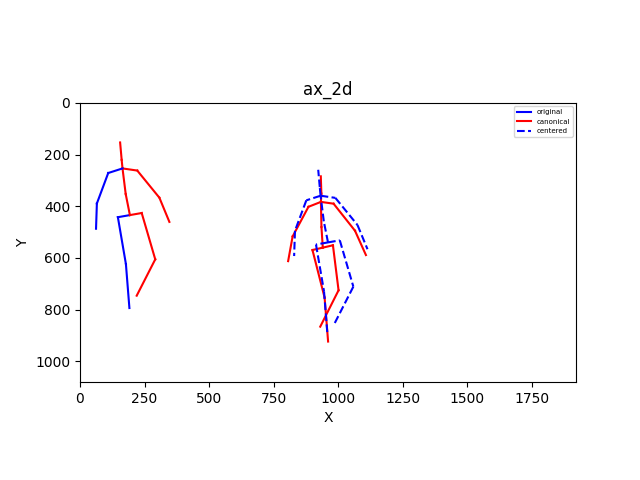

In [24]:
subject, cam_id, seq = split_source_name(data['source_list'][-1], '3dhp')

cam_param = data['cam_param'][subject][seq][cam_id].copy()
W, H, intrinsic = cam_param['W'], cam_param['H'], cam_param['intrinsic']
fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]
cam_3d = data['cam_3d'][subject][seq][cam_id].copy() #+ np.array([4, 0, -2])
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]

# Rotate cam_3d around the y-axis by 45 degrees
theta = np.radians(45)
rotation_matrix_y = Rotation.from_rotvec([0, theta, 0]).as_matrix()
#cam_3d = np.einsum('ijk,kl->ijl', cam_3d_hat, rotation_matrix_y.T) + cam_3d[:, 0:1]

cam_3d_canonical = canonicalization_cam_3d(cam_3d, canonical_type='same_z')
img_2d = projection(cam_3d, intrinsic)
img_2d_canonical = projection(cam_3d_canonical, intrinsic)
img_2d_centered = img_2d.copy() - img_2d[:, 0:1] + np.array([W/2, H/2])

camera = Camera(origin=np.array([0, 0, 0]),
                calib_mat=intrinsic,
                cam_default_R=np.eye(3),
                IMAGE_HEIGHT=H,
                IMAGE_WIDTH=W,
                cam_name='cam_frame')

# check original train data
frame_num = 0
configs = {
    'ax_2d': {'type': '2d', 'loc': 111, 'W': W, 'H': H},
}
fig, axs = generate_axes(0, configs, fig_title='')
plot_pose_setting = [
    ('ax_2d', img_2d,           {'color': '', 'label': 'original'}),
    ('ax_2d', img_2d_canonical, {'color': 'r', 'label': 'canonical'}),
    ('ax_2d', img_2d_centered,  {'color': 'b', 'linestyle': '--', 'label': 'centered'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

TS6 None None


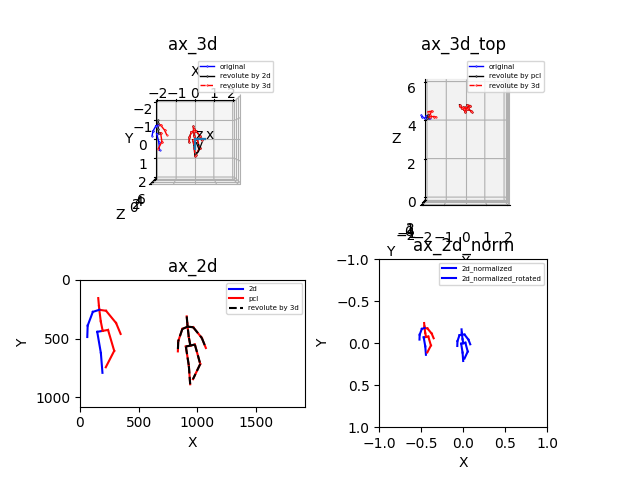

In [7]:
subject, cam_id, seq = split_source_name(data['source_list'][-1], '3dhp')
print(subject, cam_id, seq)

# camera parameters
cam_param = data['cam_param'][subject][seq][cam_id].copy()
W, H, intrinsic = cam_param['W'], cam_param['H'], cam_param['intrinsic']
fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]
# original 3D/2D pose
cam_3d = data['cam_3d'][subject][seq][cam_id].copy() #+ np.array([1, 0, -3])
img_2d = projection(cam_3d, intrinsic) # data['img_2d'][subject][seq][cam_id].copy()
# root-relative 3D pose
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]
# input centered 2D pose
img_2d_centered = img_2d.copy() - img_2d[:, 0:1] + np.array([cx, cy])

## R_virt2real from 2D pose
R_real2virt_from_2d, R_real2virt_from_2d_inv = get_batch_R_real2virt_from_2d(img_2d, intrinsic)

## R_virt2real from 3D pose
R_real2virt_no_Rz_from_3d, R_real2virt_no_Rz_from_3d_inv = get_batch_R_real2virt_from_3d(cam_3d, no_Rz=True)
R_real2virt_from_3d, R_real2virt_from_3d_inv = get_batch_R_real2virt_from_3d(cam_3d)

## canonical revolute 3D/2D pose
# by 2D pose in normalized coordinate
cam_3d_canonical_revolute_from_2d = np.einsum('ijk,ikl->ijl', cam_3d, R_real2virt_from_2d_inv)
img_2d_canonical_revolute_from_2d = projection(cam_3d_canonical_revolute_from_2d, intrinsic)
# by 3D pose in camera frame
cam_3d_canonical_revolute_from_3d = np.einsum('ijk,ikl->ijl', cam_3d, R_real2virt_from_3d_inv)
img_2d_canonical_revolute_from_3d = projection(cam_3d_canonical_revolute_from_3d, intrinsic)
cam_3d_canonical_revolute_no_Rz_from_3d = np.einsum('ijk,ikl->ijl', cam_3d, R_real2virt_no_Rz_from_3d_inv)
img_2d_canonical_revolute_no_Rz_from_3d = projection(cam_3d_canonical_revolute_no_Rz_from_3d, intrinsic)


## PCL
K_inv = np.linalg.inv(intrinsic)
norm_2d = img_2d.copy() # np.stack([img_2d, np.ones([img_2d.shape[0], img_2d.shape[1], 1])])
norm_2d = np.concatenate([norm_2d, np.ones((norm_2d.shape[0], norm_2d.shape[1], 1))], axis=-1)
norm_2d = norm_2d @ K_inv.T
norm_2d_rotated = np.einsum('ijk,ikl->ijl', norm_2d, R_real2virt_from_2d_inv)
img_2d_pcl = projection(norm_2d_rotated, intrinsic)

## check original train data
frame_num = 0
configs = {
    'ax_3d': {'type': '3d', 'loc': 221, 'mode': 'cam', 'zlim': [0, 6]},
    'ax_3d_top': {'type': '3d', 'loc': 222, 'mode': 'cam_top', 'zlim': [0, 6]},
    'ax_2d': {'type': '2d', 'loc': 223, 'W': W, 'H': H},
    'ax_2d_norm': {'type': '2d', 'loc': 224, 'normalize': True},
}
fig, axs = generate_axes(1, configs, fig_title='')
plot_pose_setting = [
    ('ax_3d', cam_3d,                        {'color': '', 'label': 'original'}),
    #('ax_3d', cam_3d_hat,                    {'color': 'y', 'label': 'root_relative'}),
    ('ax_3d', cam_3d_canonical_revolute_from_2d,     {'color': 'k', 'label': 'revolute by 2d'}),
    ('ax_3d', cam_3d_canonical_revolute_no_Rz_from_3d,    {'color': 'r', 'label': 'revolute by 3d', 'linestyle': '--'}),
    ('ax_3d_top', cam_3d,                    {'color': '', 'label': 'original'}),
    #('ax_3d_top', cam_3d_hat,                {'color': 'y', 'label': 'root_relative'}),
    ('ax_3d_top', cam_3d_canonical_revolute_from_2d, {'color': 'k', 'label': 'revolute by pcl'}),
    ('ax_3d_top', cam_3d_canonical_revolute_no_Rz_from_3d,{'color': 'r', 'label': 'revolute by 3d', 'linestyle': '--'}),
    ('ax_2d', img_2d,                        {'color': '', 'label': '2d'}),
    ('ax_2d', img_2d_pcl,                    {'color': 'r', 'label': 'pcl'}),
    ('ax_2d', img_2d_canonical_revolute_no_Rz_from_3d,    {'color': 'k', 'label': 'revolute by 3d', 'linestyle': '--'}),
    ('ax_2d_norm', norm_2d,                  {'color': '', 'label': '2d_normalized'}),
    ('ax_2d_norm', norm_2d_rotated,          {'color': 'b', 'label': '2d_normalized_rotated'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.sca(axs['ax_3d'])
# camera
camera = Camera(origin=np.array([0, 0, 0]),
                calib_mat=intrinsic,
                cam_default_R=np.eye(3),
                IMAGE_HEIGHT=H,
                IMAGE_WIDTH=W,
                cam_name='cam_frame')
camera.cam_frame.draw3d(show_name=False)
plt.show()

# Check errors

In [6]:
source_list = data['source_list'].copy()
total_error_with_revolute = 0
total_error_with_revolute_no_Rz = 0
total_error_img_2d = 0
total_error_pcl = 0
total_error_R = 0
for source in source_list:
    subject, cam_id, seq = split_source_name(data['source_list'][-1], '3dhp')

    # camera parameters
    cam_param = data['cam_param'][subject][seq][cam_id].copy()
    W, H, intrinsic = cam_param['W'], cam_param['H'], cam_param['intrinsic']
    fx, fy, cx, cy = intrinsic[0, 0], intrinsic[1, 1], intrinsic[0, 2], intrinsic[1, 2]
    # original 3D/2D pose
    cam_3d = data['cam_3d'][subject][seq][cam_id].copy()
    img_2d_saved = data['img_2d'][subject][seq][cam_id].copy()
    img_2d = projection(cam_3d, intrinsic)
    img_2d_canonical_pcl = data['img_2d_canonical_pcl'][subject][seq][cam_id].copy()

    ## R_virt2real from 2D pose
    R_real2virt_from_2d, R_real2virt_from_2d_inv = get_batch_R_real2virt_from_2d(img_2d, intrinsic)

    ## R_virt2real from 3D pose
    R_real2virt_no_Rz_from_3d, R_real2virt_no_Rz_from_3d_inv = get_batch_R_real2virt_from_3d(cam_3d, no_Rz=True)
    R_real2virt_from_3d, R_real2virt_from_3d_inv = get_batch_R_real2virt_from_3d(cam_3d)

    ## canonical revolute 3D/2D pose
    # by 2D pose in normalized coordinate
    cam_3d_canonical_revolute_from_2d = np.einsum('ijk,ikl->ijl', cam_3d, R_real2virt_from_2d_inv)
    img_2d_canonical_revolute_from_2d = projection(cam_3d_canonical_revolute_from_2d, intrinsic)
    # by 3D pose in camera frame
    cam_3d_canonical_revolute_from_3d = np.einsum('ijk,ikl->ijl', cam_3d, R_real2virt_from_3d_inv)
    img_2d_canonical_revolute_from_3d = projection(cam_3d_canonical_revolute_from_3d, intrinsic)
    cam_3d_canonical_revolute_no_Rz_from_3d = np.einsum('ijk,ikl->ijl', cam_3d, R_real2virt_no_Rz_from_3d_inv)
    img_2d_canonical_revolute_no_Rz_from_3d = projection(cam_3d_canonical_revolute_no_Rz_from_3d, intrinsic)
    # PCL
    K_inv = np.linalg.inv(intrinsic)
    norm_2d = img_2d.copy() # np.stack([img_2d, np.ones([img_2d.shape[0], img_2d.shape[1], 1])])
    norm_2d = np.concatenate([norm_2d, np.ones((norm_2d.shape[0], norm_2d.shape[1], 1))], axis=-1)
    norm_2d = norm_2d @ K_inv.T
    norm_2d_virt = np.einsum('ijk,ikl->ijl', norm_2d, R_real2virt_from_2d_inv)
    img_2d_pcl = projection(norm_2d_virt, intrinsic)
    img_2d_pcl = genertate_pcl_img_2d(img_2d_saved, cam_param)

    #assert np.allclose(img_2d_canonical_revolute[subject][action][cam_id], img_2d_canonical_pcl[subject][action][cam_id]), f'{source}'
    error_img_2d = np.linalg.norm(img_2d_saved - img_2d, axis=-1).mean()
    error_with_revolute = np.linalg.norm(img_2d_canonical_revolute_from_3d - img_2d_pcl, axis=-1).mean()
    error_with_revolute_no_Rz = np.linalg.norm(img_2d_canonical_revolute_no_Rz_from_3d - img_2d_pcl, axis=-1).mean()
    error_pcl = np.linalg.norm(img_2d_pcl - img_2d_canonical_pcl, axis=-1).mean()
    error_R = np.linalg.norm(R_real2virt_from_2d - R_real2virt_no_Rz_from_3d).mean()
    if not np.isnan(error_with_revolute): total_error_with_revolute += error_with_revolute
    if not np.isnan(error_with_revolute_no_Rz): total_error_with_revolute_no_Rz += error_with_revolute_no_Rz
    if not np.isnan(error_img_2d): total_error_img_2d += error_img_2d
    if not np.isnan(error_pcl): total_error_pcl += error_pcl
    if not np.isnan(error_R): total_error_R += error_R
total_error_with_revolute /= len(source_list)
total_error_with_revolute_no_Rz /= len(source_list)
total_error_img_2d /= len(source_list)
total_error_pcl /= len(source_list)
total_error_R /= len(source_list)
print(f'error_with_revolute: {total_error_with_revolute:.4f}')
print(f'error_with_revolute_no_Rz: {total_error_with_revolute_no_Rz:.4f}')
print(f'error_img_2d: {total_error_img_2d:.4f}')
print(f'error_pcl: {total_error_pcl:.4f}')
print(f'error_R: {total_error_R:.4f}')

error_with_revolute: 0.4726
error_with_revolute_no_Rz: 0.0000
error_img_2d: 0.0000
error_pcl: 0.0000
error_R: 0.0000


S1 cam1 Seq1


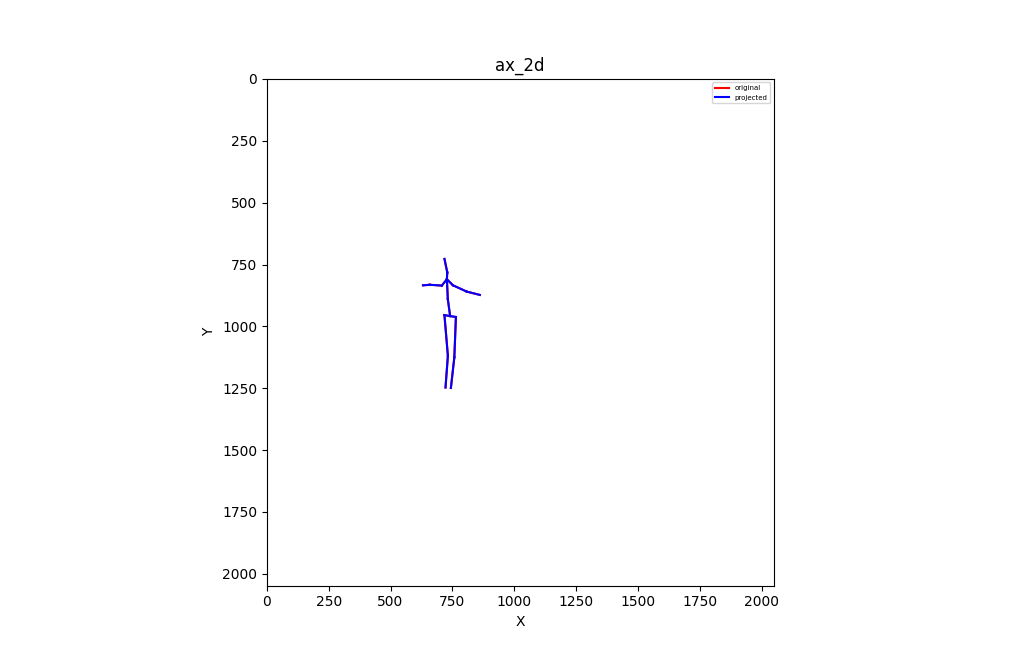

In [30]:
subject, cam_id, seq = split_source_name(data['source_list'][1], '3dhp')
print(subject, cam_id, seq)
frame_num = 0

cam_param = data['cam_param'][subject][seq][cam_id].copy()
W, H, intrinsic = cam_param['W'], cam_param['H'], cam_param['intrinsic']
cam_3d = data['cam_3d'][subject][seq][cam_id].copy()
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]
img_2d_saved = data['img_2d'][subject][seq][cam_id].copy()
img_2d = projection(cam_3d, intrinsic)

# check original train data
configs = {
    'ax_2d': {'type': '2d', 'loc': 111, 'W': W, 'H': H},
}
fig, axs = generate_axes(2, configs, fig_title='')
plot_pose_setting = [
    ('ax_2d', img_2d_saved,            {'color': 'r', 'label': 'original'}),
    ('ax_2d', img_2d,                  {'color': 'b', 'label': 'projected'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

In [32]:
img_2d[0] - img_2d_saved[0]

array([[-2.36931705e-04, -5.46974393e-04],
       [ 4.64501244e-01, -5.01525677e-01],
       [-6.68289801e-04, -4.22933116e-03],
       [ 2.34338906e-04,  1.58454903e-03],
       [ 2.57922575e-01,  6.12461963e-01],
       [-1.17832717e-05, -5.14801658e-03],
       [-1.67969096e-04, -3.37950518e-03],
       [-2.21219241e-02, -1.11062956e-01],
       [ 3.88859278e-04, -9.98195219e-05],
       [-2.05662432e-04, -2.86794496e-04],
       [-3.95866130e-04, -4.72903637e-04],
       [ 8.54107517e-04, -2.29630454e-04],
       [ 1.16434915e-03, -1.76372396e-06],
       [-1.00334966e-03, -6.00611166e-04],
       [-3.16936080e-04, -3.76747045e-04],
       [-7.10896674e-04, -8.31686881e-04],
       [-2.19381769e-04, -1.45545494e-06]])

In [31]:
np.linalg.norm(img_2d - img_2d_saved, axis=-1).mean()

0.0957800647936055

In [12]:
data_type_list = ['source_list', 'cam_param', 'cam_3d', 'img_2d', 'cam_3d_canonical_revolute', 'img_2d_canonical_revolute', 'img_2d_canonical_pcl']
overwrite_list = []
dataset_name = '3dhp'
data_aug = default_data_aug.copy()
data = load_data_dict(dataset_name, data_type_list, overwrite_list, verbose=True, data_aug=data_aug)

[overwrite: False] ==> Loading 3DHP source_list...
[overwrite: False] ==> Loading 3DHP cam_param...
[overwrite: False] ==> Loading 3DHP cam_3d...
[overwrite: False] ==> Loading 3DHP img_2d...
[overwrite: False] ==> Loading 3DHP cam_3d_canonical_revolute...
[overwrite: False] ==> Loading 3DHP img_2d_canonical_revolute...
[overwrite: False] ==> Loading 3DHP img_2d_canonical_pcl...


TS4 None None


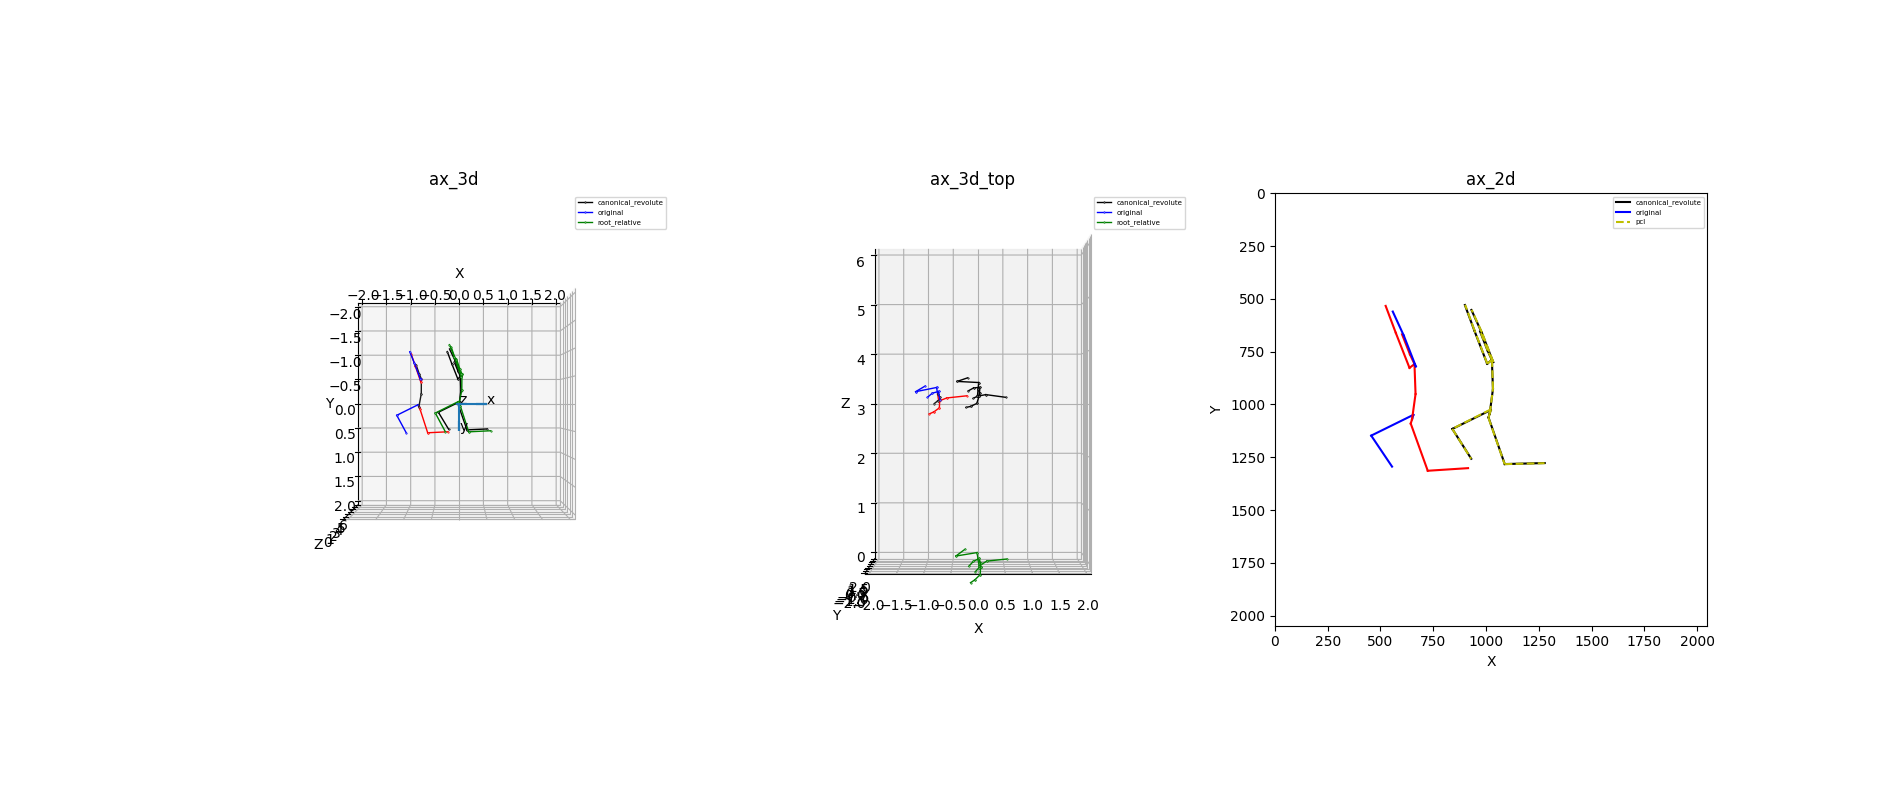

In [25]:
subject, cam_id, seq = split_source_name(data['source_list'][-1], '3dhp')
subject = 'TS4'
print(subject, cam_id, seq)
frame_num = 100

cam_param = data['cam_param'][subject][seq][cam_id].copy()
W, H, intrinsic = cam_param['W'], cam_param['H'], cam_param['intrinsic']
cam_3d = data['cam_3d'][subject][seq][cam_id].copy()
cam_3d_hat = cam_3d.copy() - cam_3d[:, 0:1]
img_2d = data['img_2d'][subject][seq][cam_id].copy()
cam_3d_canonical_revolute = data['cam_3d_canonical_revolute'][subject][seq][cam_id].copy()
img_2d_canonical_revolute = data['img_2d_canonical_revolute'][subject][seq][cam_id].copy()
img_2d_canonical_pcl = data['img_2d_canonical_pcl'][subject][seq][cam_id].copy()

# check original train data
configs = {
    'ax_3d': {'type': '3d', 'loc': 131, 'mode': 'cam', 'zlim': [0, 6]},
    'ax_3d_top': {'type': '3d', 'loc': 132, 'mode': 'cam_top', 'zlim': [0, 6]},
    'ax_2d': {'type': '2d', 'loc': 133, 'W': W, 'H': H},
}
fig, axs = generate_axes(2, configs, fig_title='')
plot_pose_setting = [
    ('ax_3d', cam_3d_canonical_revolute,            {'color': 'k', 'label': 'canonical_revolute'}),
    ('ax_3d', cam_3d,                               {'color': '', 'label': 'original'}),
    ('ax_3d', cam_3d_hat,                           {'color': 'g', 'label': 'root_relative'}),
    ('ax_3d_top', cam_3d_canonical_revolute,        {'color': 'k', 'label': 'canonical_revolute'}),
    ('ax_3d_top', cam_3d,                           {'color': '', 'label': 'original'}),
    ('ax_3d_top', cam_3d_hat,                       {'color': 'g', 'label': 'root_relative'}),
    ('ax_2d', img_2d_canonical_revolute,            {'color': 'k', 'label': 'canonical_revolute'}),
    ('ax_2d', img_2d,                               {'color': '', 'label': 'original'}),
    ('ax_2d', img_2d_canonical_pcl,                 {'color': 'y', 'label': 'pcl', 'linestyle': '--'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.sca(axs['ax_3d'])
camera.cam_frame.draw3d(show_name=False)
plt.show()

# Individual joint error with changing target center p

In [30]:
l_wrist_id = get_h36m_keypoint_index('l_wrist')
l_elbow_id = get_h36m_keypoint_index('l_elbow')
l_shoulder_id = get_h36m_keypoint_index('l_shoulder')
r_wrist_id = get_h36m_keypoint_index('r_wrist')
r_elbow_id = get_h36m_keypoint_index('r_elbow')
r_shoulder_id = get_h36m_keypoint_index('r_shoulder')
l_arm_id = [l_shoulder_id, l_elbow_id, l_wrist_id]
r_arm_id = [r_shoulder_id, r_elbow_id, r_wrist_id]

l_ankle_id = get_h36m_keypoint_index('l_ankle')
l_knee_id = get_h36m_keypoint_index('l_knee')
l_hip_id = get_h36m_keypoint_index('l_hip')
r_ankle_id = get_h36m_keypoint_index('r_ankle')
r_knee_id = get_h36m_keypoint_index('r_knee')
r_hip_id = get_h36m_keypoint_index('r_hip')
l_leg_id = [l_hip_id, l_knee_id, l_ankle_id]
r_leg_id = [r_hip_id, r_knee_id, r_ankle_id]

In [39]:
from hpe_library.my_utils.test_utils import h36m_keypoints
h36m_keypoints

{0: 'Pelvis',
 1: 'R_Hip',
 2: 'R_Knee',
 3: 'R_Ankle',
 4: 'L_Hip',
 5: 'L_Knee',
 6: 'L_Ankle',
 7: 'Torso',
 8: 'Neck',
 9: 'Nose',
 10: 'Head',
 11: 'L_Shoulder',
 12: 'L_Elbow',
 13: 'L_Wrist',
 14: 'R_Shoulder',
 15: 'R_Elbow',
 16: 'R_Wrist'}

Pelvis
R_Hip
R_Knee
R_Ankle
L_Hip
L_Knee
L_Ankle
Torso
Neck
Nose
Head
L_Shoulder
L_Elbow
L_Wrist
R_Shoulder
R_Elbow
R_Wrist


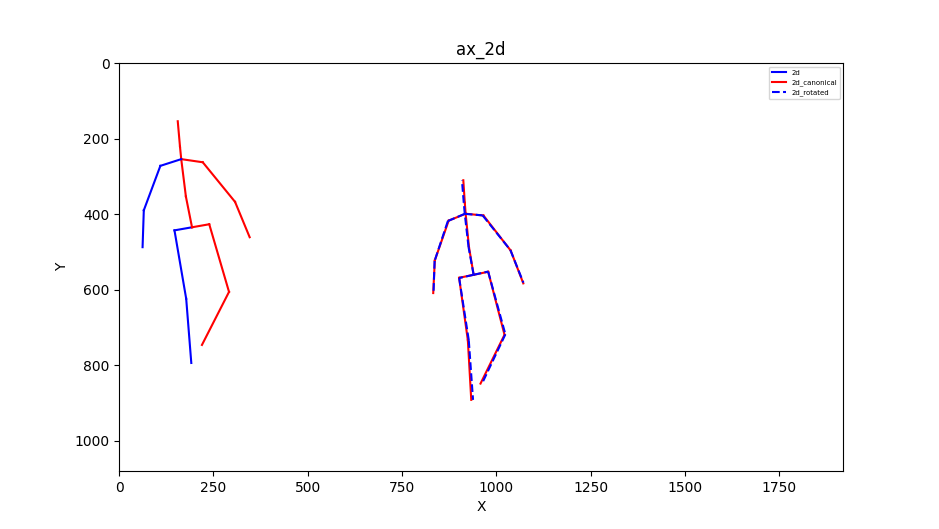

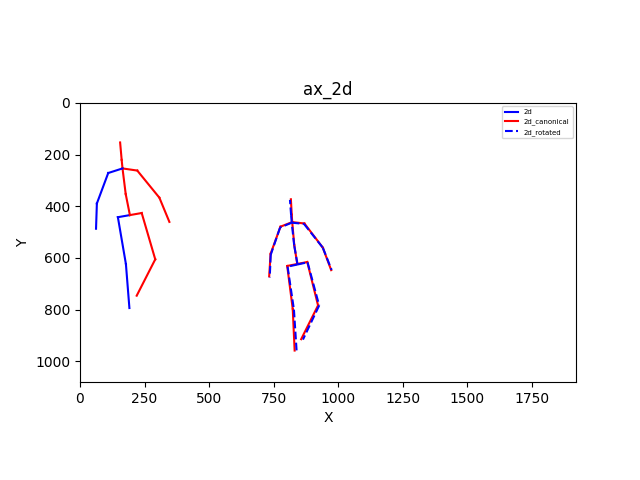

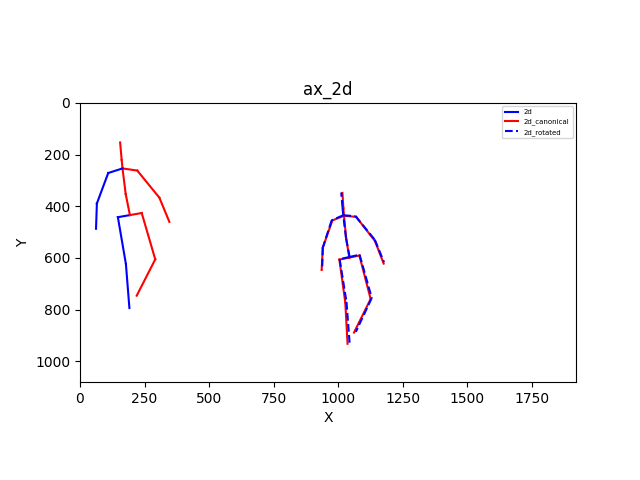

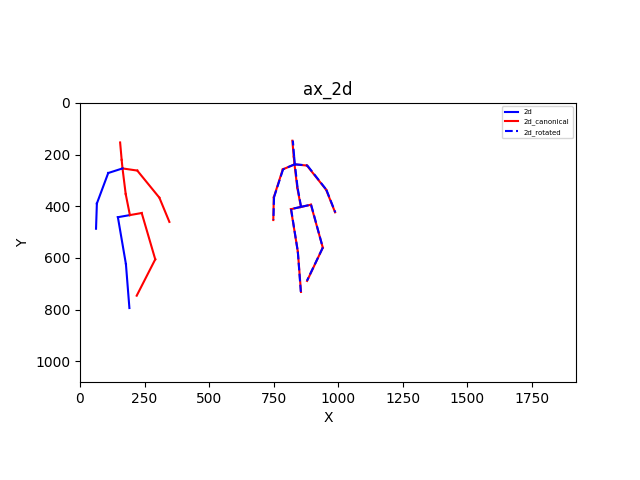

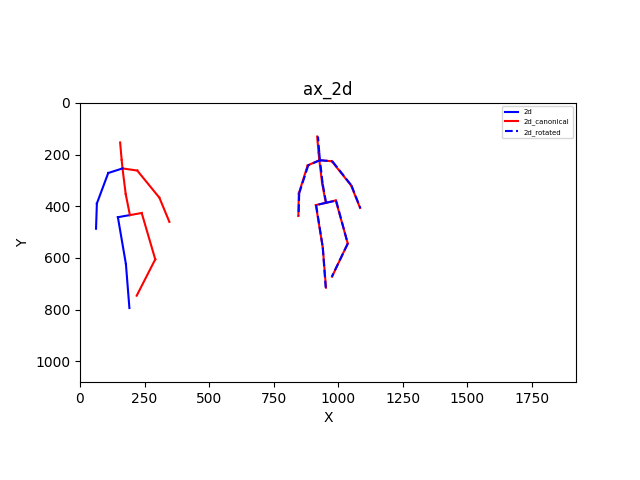

target joint,Pelvis,R_Hip,R_Knee,R_Ankle,L_Hip,L_Knee,L_Ankle,Torso,Neck,Nose,Head,L_Shoulder,L_Elbow,L_Wrist,R_Shoulder,R_Elbow,R_Wrist
pelvis,0.000,0.081,0.529,0.947,0.082,0.537,0.960,0.226,0.495,0.584,0.762,0.470,0.471,0.582,0.476,0.397,0.443
l_elbow,1.634,1.785,3.176,4.426,1.510,2.988,4.322,1.166,0.934,1.000,1.318,0.704,0.000,0.595,1.159,1.566,2.006
r_elbow,1.218,1.097,2.398,3.530,1.369,2.595,3.706,0.835,0.814,0.960,1.329,0.985,1.397,1.841,0.602,0.000,0.480
l_knee,0.590,0.617,0.267,0.501,0.578,0.000,0.484,0.838,1.143,1.245,1.453,1.099,1.121,1.205,1.129,1.107,1.137
r_knee,0.590,0.575,0.000,0.470,0.622,0.275,0.585,0.841,1.151,1.256,1.468,1.135,1.205,1.307,1.108,1.010,0.973


In [62]:
from prettytable import PrettyTable
x = PrettyTable()
field_names = ["target joint"]
for joint in h36m_keypoints:
    key = h36m_keypoints[joint]
    print(key)
    field_names.append(key)
x.field_names = field_names

for i, target_joint in enumerate(['pelvis', 'l_elbow', 'r_elbow', 'l_knee', 'r_knee']):

    joint_id = get_h36m_keypoint_index(target_joint)

    dist = np.linalg.norm(cam_3d[:, joint_id], axis=1)
    v_origin_to_joint = cam_3d[:, joint_id] / dist[:, None]
    v_origin_to_revolute = np.array([0, 0, 1]).reshape(1, 3).repeat(len(cam_3d), axis=0)
    assert v_origin_to_revolute.shape == v_origin_to_joint.shape, (v_origin_to_revolute.shape, v_origin_to_joint.shape)

    rot_joint_to_revolute = batch_rotation_matrix_from_vectors(v_origin_to_joint, v_origin_to_revolute)
    rot_revolute_to_joint = batch_rotation_matrix_from_vectors(v_origin_to_revolute, v_origin_to_joint)


    K = intrinsic.copy()
    K_inv = np.linalg.inv(K)
    locations = img_2d[:, joint_id]
    locations = np.hstack([locations, np.ones((locations.shape[0], 1))]) # to homogeneous coordinates
    locations = locations @ K_inv.T

    R_virt2reals = batch_virtualCameraRotationFromPosition(locations)
    R_real2virts = np.linalg.inv(R_virt2reals)

    cam_3d_hat = cam_3d.copy() - cam_3d[:, joint_id:joint_id+1]
    cam_3d_hat_rotated1 = np.einsum('ijk,ikl->ijl', cam_3d_hat.copy(), rot_joint_to_revolute)
    cam_3d_hat_rotated2 = np.einsum('ijk,ikl->ijl', cam_3d_hat.copy(), R_virt2reals)
    # cam_3d_canonical_revolute1 = cam_3d_hat_rotated1.copy()
    # cam_3d_canonical_revolute1[:, :, 2] += dist[:, None]
    cam_3d_canonical_revolute1 = np.einsum('ijk,ikl->ijl', cam_3d.copy(), rot_revolute_to_joint)
    cam_3d_canonical_revolute2 = cam_3d_hat_rotated2.copy()
    cam_3d_canonical_revolute2[:, :, 2] += dist[:, None]
    img_2d_canonical_revolute = projection(cam_3d_canonical_revolute1, intrinsic)

    norm_2d = img_2d.copy() # np.stack([img_2d, np.ones([img_2d.shape[0], img_2d.shape[1], 1])])
    norm_2d = np.concatenate([norm_2d, np.ones((norm_2d.shape[0], norm_2d.shape[1], 1))], axis=-1)
    norm_2d = norm_2d @ K_inv.T

    norm_2d_rotated = np.einsum('ijk,ikl->ijl', norm_2d, R_virt2reals)
    img_2d_rotated = projection(norm_2d_rotated, intrinsic)

    # check original train data
    configs = {
        #'ax_3d': {'type': '3d', 'loc': 221, 'mode': 'cam', 'zlim': [0, 6]},
        #'ax_3d_top': {'type': '3d', 'loc': 222, 'mode': 'cam_top', 'zlim': [0, 6]},
        'ax_2d': {'type': '2d', 'loc': 111, 'W': W, 'H': H},
        #'ax_2d_norm': {'type': '2d', 'loc': 224, 'normalize': True},
    }
    fig, axs = generate_axes(2+i, configs, fig_title='')
    plot_pose_setting = [
        # ('ax_3d', cam_3d_canonical_revolute1,           {'color': 'k', 'label': 'revolute by custom'}),
        # ('ax_3d', cam_3d_canonical_revolute2,           {'color': 'y', 'linestyle': '--', 'linewidth': 0.1, 'label': 'revolute by R_orig2virt'}),
        # ('ax_3d', cam_3d,                               {'color': '', 'label': 'original'}),
        # ('ax_3d', cam_3d_hat,                           {'color': 'g', 'label': 'root_relative'}),
        # ('ax_3d_top', cam_3d_canonical_revolute1,           {'color': 'k', 'label': 'revolute by custom'}),
        # ('ax_3d_top', cam_3d_canonical_revolute2,           {'color': 'y', 'linestyle': '--', 'label': 'revolute by R_orig2virt'}),
        # ('ax_3d_top', cam_3d,                               {'color': '', 'label': 'original'}),
        # ('ax_3d_top', cam_3d_hat,                           {'color': 'g', 'label': 'root_relative'}),
        ('ax_2d', img_2d,                               {'color': '', 'label': '2d'}),
        ('ax_2d', img_2d_canonical_revolute,            {'color': 'r', 'label': '2d_canonical'}),
        #('ax_2d', img_2d_centered,                      {'color': 'g', 'label': '2d_centered'}),
        #('ax_2d_norm', norm_2d,                         {'color': '', 'label': '2d_normalized'}),
        #('ax_2d_norm', norm_2d_rotated,                 {'color': 'b', 'label': '2d_normalized_rotated'}),
        ('ax_2d', img_2d_rotated,                       {'color': 'b', 'linestyle': '--', 'label': '2d_rotated'}),
    ]
    general_plot_func(axs, configs, plot_pose_setting, frame_num)
    #plt.sca(axs['ax_3d'])
    #camera.cam_frame.draw3d(show_name=False)
    plt.show()

    #error_l_arm = np.linalg.norm(img_2d_canonical_revolute[:, l_arm_id] - img_2d_rotated[:, l_arm_id], axis=2).mean()
    #error_r_arm = np.linalg.norm(img_2d_canonical_revolute[:, r_arm_id] - img_2d_rotated[:, r_arm_id], axis=2).mean()
    #error_l_leg = np.linalg.norm(img_2d_canonical_revolute[:, l_leg_id] - img_2d_rotated[:, l_leg_id], axis=2).mean()
    #error_r_leg = np.linalg.norm(img_2d_canonical_revolute[:, r_leg_id] - img_2d_rotated[:, r_leg_id], axis=2).mean()

    #print(f"{joint} -> l_arm: {error_l_arm:.2f}, r_arm: {error_r_arm:.2f}, l_leg: {error_l_leg:.2f}, r_leg: {error_r_leg:.2f}")
    row = [target_joint]
    for joint in h36m_keypoints.keys():
        joint_name = h36m_keypoints[joint]
        error = np.linalg.norm(img_2d_canonical_revolute[:, joint] - img_2d_rotated[:, joint], axis=1).mean()
        #print(f"{joint_name}: {error:.2f}")
        row.append(f"{error:.3f}")
    x.add_row(row)
x

In [24]:
error_l_arm

0.5074827054156711